# Controlnet

diffusers
transformers
torch
torchvision*
accelerate

Control net donesn't change the original unet. Instead, it uses another smaller network in parallel to the original unet to influence its output.
Thus, the trainable parameters are much less since the controlnet is smaller than the original unet.
So the trianing is faster and requires less memories.

## utils

In [117]:
import torch
device = "cuda:0" if torch.cuda.is_available else "cpu"
print(device)


cuda:0


In [ ]:
import numpy as np
import torch.nn as nn
import os, torch, copy, cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from torchvision.utils import make_grid

In [ ]:
def get_num_parameters(net, only_trainable=False):
    return sum(p.numel() for p in net.parameters() if p.require_grads == True and only_trainable == True)

## Train base unet

So first, we need a trained diffusion unet. If you use the pretrained one or already have one, skip this section

In [11]:
#### create unet

from diffusers import UNet2DModel
unet = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)

In [114]:
#### prepare data

import PIL.Image as Image
import torch.utils.data as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

batch_size = 128

# load dataset
data_transforms = [
    transforms.ToTensor(), # convert to the range [0,1]
    transforms.Lambda(lambda x: x * 2 - 1) # convert to the range [-1,1]
]
data_transforms = transforms.Compose(data_transforms)
data = datasets.MNIST("./mnist", download=False, transform=data_transforms)

# dataloaders
train_loader = utils.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [286]:
#### define train loop

def train(epochs, net, data_loader, scheduler, use_cls=False):
    
    num_epochs = epochs

    net = net.to(device)

    loss_fn = nn.MSELoss()

    optim = torch.optim.Adam(net.parameters(), lr=1e-3)

    losses = []

    net.train()

    for e in range(num_epochs):

        for x, l in tqdm(data_loader):

            x = x.to(device)
            #l = l.to(device)

            z = torch.randn_like(x).to(device)

            ts = torch.randint(0, 1000, (x.shape[0], )).to(device)

            x_noisy = scheduler.add_noise(x, z, ts)

            if (use_cls):
                pred = net(x_noisy, ts, l).sample
            else:
                pred = net(x_noisy, ts).sample

            loss = loss_fn(pred, z)

            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())

        epoch_loss = sum(losses[-len(train_loader):]) / len(train_loader)
        print(f"Epoch {e} / {num_epochs} - loss: {epoch_loss:04f}")

    return losses

In [ ]:
#### train

unet = unet.to(device)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
LLosses = train(10, unet, train_loader, scheduler)

# save the weights
path = "./tmp/mnistunet.pth"
torch.save(unet.state_dict(), path)

In [161]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def generate(net, scheduler, num = 100, use_cls=False, cond=None):

    x = torch.randn(num, 1, 28, 28).to(device)
    if use_cls:
        y = torch.tensor([[i]*10 for i in range(1,num%10+1)]).flatten().to(device)

    # Sampling loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):

        # Get model pred
        with torch.no_grad():
            if (use_cls):
                pred = net(x, t, y).sample
            elif cond is not None:
                pred = net(x, t, cond)
            else:
                pred = net(x, t).sample

        # Update sample with step
        x = scheduler.step(pred, t, x).prev_sample

    # Show the results
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(make_grid(x.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')

In [ ]:
#### check results

generate(unet, scheduler)

## Control with canny

In [306]:
# controlnet

class MNISTUNetL(nn.Module) :

    @staticmethod
    def zero_module(module):
        """
        Zero out the parameters of a module and return it.
        """
        for p in module.parameters():
            p.detach().zero_()
        return module


    def __init__(self):

        super().__init__()

        # original unet
        self.unet = UNet2DModel(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

        # load the orignal unet weights
        path = "./tmp/mnistunet.pth"
        if not os.path.exists(path):
            raise FileNotFoundError("Model file not found!")
        else:
            self.unet.load_state_dict(torch.load(path, map_location=device))
            print("Model loaded successfully!")

        # freeze the original unet weights
        for params in self.unet.parameters():
            params.requires_grad = False

        # define controlnet
        ch = self.unet.config.block_out_channels[0]

        # define downblocks
        self.down_blocks = nn.ModuleList([copy.deepcopy(block) for block in self.unet.down_blocks])
        self.mid_block = copy.deepcopy(self.unet.mid_block)

        # define zero conv layers
        self.zeroconv_input = MNISTUNetL.zero_module(nn.Conv2d(1, ch, kernel_size=1, stride=1, padding=0))
        self.zeroconvs = nn.ModuleList([MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0))])

        for i in range(len(self.down_blocks)):
            # zero conv layer for all resnet block
            for j in range(self.unet.config.layers_per_block):
                ch = self.unet.config.block_out_channels[i]
                self.zeroconvs.append(MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0)))
            # if it is the final block, we need a zero conv layer too
            if hasattr(self.unet.down_blocks[i], "downsamplers"):
                ch = self.unet.config.block_out_channels[i]
                self.zeroconvs.append(MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0)))
        # define mid block and its zero conv layer
        mid_ch = self.unet.config.block_out_channels[-1]
        self.zeroconv_mid_block = MNISTUNetL.zero_module(nn.Conv2d(mid_ch, mid_ch, kernel_size=1, stride=1, padding=0))


    def forward(self, x, t, c):

        # preprocess time
        if not torch.is_tensor(t):
            if isinstance(t, float) or isinstance(t, int):
                t = torch.tensor([t], dtype=torch.float32, device=x.device)
        elif torch.is_torch(t) and len(t) == 1:
            t = t.expand(x.shape[0], dtype=torch.float32, device=x.device)
        elif len(t) == len(x):
            t = torch.tensor(t, dtype=torch.float32, device=x.device)
        t = t.expand(x.shape[0])

        # time projection
        emb_t = self.unet.time_proj(t) # (batch, ) -> (batch, 32)
        emb_t = self.unet.time_embedding(emb_t) # (batch, 32) -> (batch, 128), 12_ is the dim of linear input dim of attention block

        # pre_process of input
        out_legacy = self.unet.conv_in(x) # (batch, 32, 28, 28)

        ##### Condition #####

        # pre-process on condition side
        out_c = self.zeroconv_input(c) # c (batch, 1, 28, 28)
        out = out_c + out_legacy # x (batch, 1, 28, 28)

        # downblocks
        down_block_res = (out, ) # tuple of tensor(batch, 32, 28, 28)

        for block in self.down_blocks:
            out, res = block(hidden_states=out, temb=emb_t)
            down_block_res += res

        # mid block
        out = self.mid_block(hidden_states=out, temb=emb_t)

        # zeroconvs
        zeroconv_res = ()
        for res, zeroconv in zip(down_block_res, self.zeroconvs):
            res = zeroconv(res)
            zeroconv_res += (res,)

        zeroconv_mid_res = self.zeroconv_mid_block(out)

        #### unet ####

        # down blocks
        legacy_down_block_res = (out_legacy,)
        for down in self.unet.down_blocks:
            out_legacy, res = down(hidden_states=out_legacy, temb=emb_t)
            legacy_down_block_res += res

        # mid block
        out_legacy = self.unet.mid_block(out_legacy, emb_t)

        out_mix = out_legacy + zeroconv_mid_res

        # upblocks

        for up in self.unet.up_blocks:
            # pop the res of the unet downblocks
            res_legacy = legacy_down_block_res[-len(up.resnets) :]
            legacy_down_block_res = legacy_down_block_res[: -len(up.resnets)] # pop the res when done

            # pop the res of the controlnet downblocks
            res_zero = zeroconv_res[-len(up.resnets) :]
            zeroconv_res = zeroconv_res[: -len(up.resnets)] # pop the res when done
            out_mix = up(out_mix, res_legacy+res_zero, emb_t)

        # post process
        out_mix = self.unet.conv_norm_out(out_mix)
        out_mix = self.unet.conv_act(out_mix)
        out_mix = self.unet.conv_out(out_mix)

        return out_mix

# # tests
# net = MNISTUNetL()
# input_x = torch.randn((10, 1, 28, 28))
# input_t = torch.randn((10, ))
# input_c = torch.randn((10, 1, 28, 28))
# output = net(input_x, input_t, input_c)
# print(output.shape)
# should output
#   Model loaded successfully!
#   torch.Size([10, 1, 28, 28])

In [ ]:
# we use canny edge as the condition

def get_canny(imgs:torch.Tensor) -> torch.Tensor:
    """
    Apply Canny edge detection to a batch of images.
    """
    cannies = torch.empty(imgs.shape)
    for i, img in enumerate(imgs):
        img = img[0]
        img = img.to(torch.uint8).numpy()
        canny = cv2.Canny(img, 100, 200)
        canny = torch.tensor(canny[np.newaxis,], dtype=torch.float32).clamp(0,1.0)
        cannies[i] = canny.unsqueeze(0)
    return cannies

cannies = get_canny(next(iter(train_loader))[0])
print(cannies.shape)
print(cannies.dtype)

torch.Size([128, 1, 28, 28])
torch.float32


In [127]:
# train loop
def train_cond(epochs, net, data_loader, scheduler, lr=1e-3):
    
    num_epochs = epochs

    net = net.to(device)

    loss_fn = nn.MSELoss()

    optim = torch.optim.Adam(net.parameters(), lr=lr)

    losses = []

    net.train()

    for e in range(num_epochs):

        for x, l in tqdm(data_loader):

            cannies = get_canny(x).to(device)
            x = x.to(device)

            z = torch.randn_like(x).to(device)

            ts = torch.randint(0, 1000, (x.shape[0], )).to(device)

            x_noisy = scheduler.add_noise(x, z, ts)

            pred = net(x_noisy, ts, cannies)

            loss = loss_fn(pred, z)

            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())

        epoch_loss = sum(losses[-len(train_loader):]) / len(train_loader)
        print(f"Epoch {e} / {num_epochs} - loss: {epoch_loss:04f}")

    return losses

In [ ]:
# train
cond_net = MNISTUNetL()
cond_net = cond_net.to(device)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
LLosses = train_cond(10, cond_net, train_loader, scheduler)

0it [00:00, ?it/s]

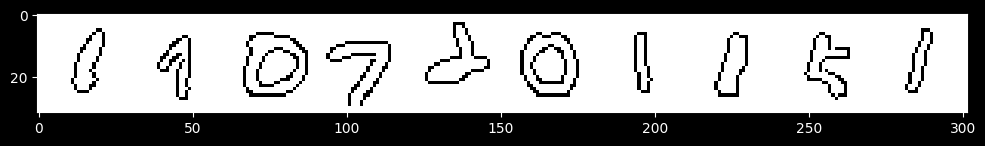

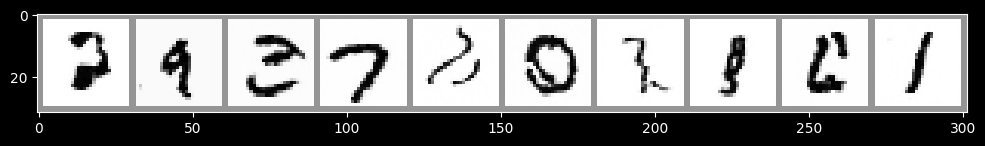

In [335]:
# show results
x = torch.randn(10, 1, 28, 28).to(device)
c = get_canny(next(iter(train_loader))[0][:10]).to(device)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(c.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')
generate(cond_net, scheduler, num=10, cond=c)

## Controlnet

This is the same as the previous section, but we refactor the code to separate the controlnet and the unet.

In [397]:
# controlnet
class ControlNet(nn.Module) :

    @staticmethod
    def zero_module(module):
        """
        Zero out the parameters of a module and return it.
        """
        for p in module.parameters():
            p.detach().zero_()
        return module
    
    def freeze_layer(self, layer):
        for p in layer.parameters():
            p.requires_grad = False

    def copy_block(self, net, block_name, state_dict):
        found = False
        with torch.no_grad():
            for name, layer in net.named_parameters():
                if block_name in name:
                    mylayer = copy.deepcopy(layer)
                    mylayer.copy_(state_dict[name])

        return eval("net."+block_name)


    def __init__(self, unet:UNet2DModel, state_dict):

        super().__init__()

        # get the layers from unet
        self.conv_in = self.copy_block(unet, "conv_in", state_dict)
        self.freeze_layer(self.conv_in)
        self.time_proj = self.copy_block(unet, "time_proj", state_dict)
        self.freeze_layer(self.time_proj)
        self.time_embedding = self.copy_block(unet, "time_embedding", state_dict)
        self.freeze_layer(self.time_embedding)

        # define controlnet
        ch = unet.config.block_out_channels[0]

        # define downblocks
        self.down_blocks = nn.ModuleList([copy.deepcopy(block) for block in unet.down_blocks])
        self.mid_block = copy.deepcopy(unet.mid_block)

        # define zero conv layers
        self.zeroconv_input = MNISTUNetL.zero_module(nn.Conv2d(1, ch, kernel_size=1, stride=1, padding=0))
        self.zeroconvs = nn.ModuleList([MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0))])

        for i in range(len(self.down_blocks)):
            # zero conv layer for all resnet block
            for j in range(unet.config.layers_per_block):
                ch = unet.config.block_out_channels[i]
                self.zeroconvs.append(MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0)))
            # if it is the final block, we need a zero conv layer too
            if hasattr(unet.down_blocks[i], "downsamplers"):
                ch = unet.config.block_out_channels[i]
                self.zeroconvs.append(MNISTUNetL.zero_module(nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0)))
        # define mid block and its zero conv layer
        mid_ch = unet.config.block_out_channels[-1]
        self.zeroconv_mid_block = MNISTUNetL.zero_module(nn.Conv2d(mid_ch, mid_ch, kernel_size=1, stride=1, padding=0))


    def forward(self, x, t, c):

        # preprocess time
        if not torch.is_tensor(t):
            if isinstance(t, float) or isinstance(t, int):
                t = torch.tensor([t], dtype=torch.float32, device=x.device)
        elif len(t) == len(x):
            t = torch.tensor(t, dtype=torch.float32, device=x.device)
        t = t.expand(x.shape[0])

        # time projection
        emb_t = self.time_proj(t) # (batch, ) -> (batch, 32)
        emb_t = self.time_embedding(emb_t) # (batch, 32) -> (batch, 128), 12_ is the dim of linear input dim of attention block

        # pre_process of input
        out_legacy = self.conv_in(x) # (batch, 32, 28, 28)

        ##### Condition #####

        # pre-process on condition side
        out_c = self.zeroconv_input(c) # c (batch, 1, 28, 28)
        out = out_c + out_legacy # x (batch, 1, 28, 28)

        # downblocks
        down_block_res = (out, ) # tuple of tensor(batch, 32, 28, 28)

        for block in self.down_blocks:
            out, res = block(hidden_states=out, temb=emb_t)
            down_block_res += res

        # mid block
        out = self.mid_block(hidden_states=out, temb=emb_t)

        # zeroconvs
        zeroconv_res = ()
        for res, zeroconv in zip(down_block_res, self.zeroconvs):
            res = zeroconv(res)
            zeroconv_res += (res,)

        zeroconv_mid_res = self.zeroconv_mid_block(out)

        return zeroconv_res, zeroconv_mid_res

In [398]:
# controlnet + unet
class DFUnetCondition2D(nn.Module):
    def __init__(self, orignal_unet, state_path="./tmp/mnistunet.pth"):

        super().__init__()
        self.unet = orignal_unet

        # load the orignal unet weights
        if not os.path.exists(state_path):
            raise FileNotFoundError("Model file not found!")
        else:
            state_dict = torch.load(path, map_location=device)
            self.unet.load_state_dict(state_dict)
            print("Model loaded successfully!")

        # freeze the original unet weights
        for params in self.unet.parameters():
            params.requires_grad = False

        self.controlnet = ControlNet(unet, state_dict)

    def save_controlnet(self, path):
        torch.save(self.controlnet.state_dict(), path)

    def save_unet(self, path):
        torch.save(self.unet.state_dict(), path)

    def forward(self, x, t, c):
        controlnet_res, controlnet_mid_res = self.controlnet(x, t, c)

        # preprocess time
        if not torch.is_tensor(t):
            if isinstance(t, float) or isinstance(t, int):
                t = torch.tensor([t], dtype=torch.float32, device=x.device)
        elif len(t) == len(x):
            t = torch.tensor(t, dtype=torch.float32, device=x.device)
        t = t.expand(x.shape[0])

        # time projection
        emb_t = self.unet.time_proj(t) # (batch, ) -> (batch, 32)
        emb_t = self.unet.time_embedding(emb_t) # (batch, 32) -> (batch, 128), 12_ is the 
        out = self.unet.conv_in(x) # (batch, 32, 28, 28)

        #### unet ####

        # down blocks
        down_block_res = (out,)
        for down in self.unet.down_blocks:
            out, res = down(hidden_states=out, temb=emb_t)
            down_block_res += res

        # mid block
        out = self.unet.mid_block(out, emb_t)
        out = out + controlnet_mid_res

        # upblocks
        for up in self.unet.up_blocks:
            # pop the res of the unet downblocks
            res = down_block_res[-len(up.resnets) :]
            down_block_res = down_block_res[: -len(up.resnets)] # pop the res when done
            res_zero = controlnet_res[-len(up.resnets) :] # pop the res of the controlnet downblocks
            controlnet_res = controlnet_res[: -len(up.resnets)] # pop the res when done
            out = up(out, res+res_zero, emb_t)

        # post process
        out = self.unet.conv_norm_out(out)
        out = self.unet.conv_act(out)
        out = self.unet.conv_out(out)
        return out

In [402]:
# state_dict = torch.load("./tmp/mnistunet.pth")
controlnet = DFUnetCondition2D(unet)

print(f"Unet has {get_num_parameters(unet)} parameters and controlnet has {get_num_parameters(controlnet.controlnet)} parameters")

Model loaded successfully!
Unet has 4023233 parameters and controlnet has 1759584 parameters


In [400]:
# train
controlnet = controlnet.to(device)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
LLosses = train_cond(10, controlnet, train_loader, scheduler)

0it [00:00, ?it/s]

/tmp/ipykernel_6701/3638192958.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, device=x.device)
/tmp/ipykernel_6701/2379625522.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, device=x.device)


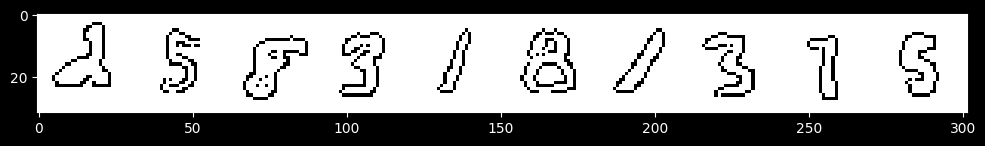

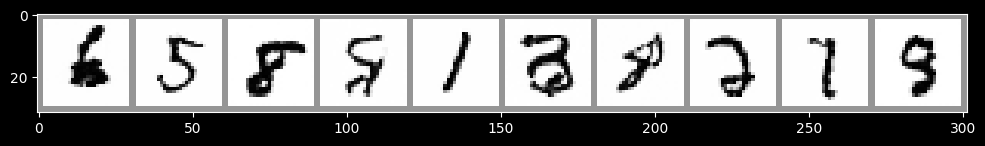

In [401]:
x = torch.randn(10, 1, 28, 28).to(device)
c = get_canny(next(iter(train_loader))[0][:10]).to(device)

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(c.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')
generate(controlnet, scheduler, num=10, cond=c)

## T2I

This is simplier than controlnet. It consists of a parallel network called T2I-Adapter injected into the unet's encoder.

In [101]:
# building blocks for adapter

class ResBlock(nn.Module):
    def __init__(self, ch, skip=False):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, 1, 1)
        self.act = nn.ReLU()
        self.conv2 = nn.Conv2d(ch, ch, 1, 1, 0)
        if skip:
            self.skip = nn.Conv2d(ch, ch, 3, 1, 1)
        else:
            self.skip = None
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.act(h)
        h = self.conv2(h)
        if self.skip is not None:
            return h + self.skip(x)
        return x + h
    
class AdapterBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_rb=2, down=False, skip=False):
        super().__init__()
        if in_ch != out_ch:
            self.in_conv = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        else:
            self.in_conv = None
        self.down = down
        if self.down:
            self.down = nn.AvgPool2d(2, 2)
        self.res_blocks = [ResBlock(out_ch, skip) for i in range(num_rb)]
        self.res_blocks = nn.Sequential(*self.res_blocks)
        

    def forward(self, x):
        h = x
        if self.down:
            h = self.down(h)
        if self.in_conv is not None:
            h = self.in_conv(h)
        h = self.res_blocks(h)
        return h
    
class Adapter(nn.Module):
    def __init__(self, channels=[32, 64, 128], cin=1, num_rb=2):
        super().__init__()
        self.unshuffle = nn.PixelUnshuffle(2)
        self.channels = channels
        self.num_rb = num_rb
        self.body = []
        
        for i, ch in enumerate(channels):
            if i == 0:
                self.body.append(AdapterBlock(cin*4, channels[0], down=False))
            elif i == len(channels) - 1:
                self.body.append(AdapterBlock(channels[i-1], channels[i], down=False))
            else:
                self.body.append(AdapterBlock(channels[i-1], channels[i], down=True))
        self.body = nn.ModuleList(self.body)

    def forward(self, x):
        x = self.unshuffle(x)
        res = []
        for i in range(len(self.channels)):
            x = self.body[i](x)
            res.append(x)
        return res

In [ ]:
adapter = Adapter()

print(f"Unet has {get_num_parameters(unet)} parameters and ti2 has {get_num_parameters(adapter)} parameters")

Unet has 4023233 parameters and ti2 has 524512 parameters


In [148]:
# T2I + unet

class T2INet(nn.Module) :
    
    def freeze_layer(self, layer):
        for p in layer.parameters():
            p.requires_grad = False


    def __init__(self, unet, channels=[32, 64, 128], cin=1, num_rb=2):

        super().__init__()
        self.channels = channels
        self.adapter = Adapter()
        self.unet = unet

        # load the orignal unet weights
        path = "./tmp/mnistunet.pth"
        if not os.path.exists(path):
            raise FileNotFoundError("Model file not found!")
        else:
            self.unet.load_state_dict(torch.load(path, map_location=device))
            print("Model loaded successfully!")
            
        for params in self.unet.parameters():
            params.requires_grad = False


    def forward(self, x, t, c):

        # preprocess time
        if not torch.is_tensor(t):
            if isinstance(t, float) or isinstance(t, int):
                t = torch.tensor([t], dtype=torch.float32, device=x.device)
        elif torch.is_tensor(t) and len(t) == 1:
            t = t.expand(x.shape[0], dtype=torch.float32, device=x.device)
        elif len(t) == len(x):
            t = torch.tensor(t, dtype=torch.float32, device=x.device)
        t = t.expand(x.shape[0])

        ##### Condition #####
        adapter_res = self.adapter(c)

        # time projection
        emb_t = self.unet.time_proj(t) # (batch, ) -> (batch, 32)
        emb_t = self.unet.time_embedding(emb_t) # (batch, 32) -> (batch, 128), 12_ is the dim of linear input dim of attention block

        # pre_process of input
        out = self.unet.conv_in(x) # (batch, 32, 28, 28)

        #### unet ####
        # down blocks
        down_block_res = (out,)
        for down in self.unet.down_blocks:
            out, res = down(hidden_states=out, temb=emb_t)
            down_block_res += res
            out += adapter_res.pop(0)

        # mid block
        out = self.unet.mid_block(out, emb_t)

        # upblocks
        for up in self.unet.up_blocks:
            # pop the res of the unet downblocks
            res = down_block_res[-len(up.resnets) :]
            down_block_res = down_block_res[: -len(up.resnets)] # pop the res when done
            out = up(out, res, emb_t)

        # post process
        out = self.unet.conv_norm_out(out)
        out = self.unet.conv_act(out)
        out = self.unet.conv_out(out)

        return out

In [ ]:
# train, same as the controlnet

cond_t2i = T2INet(unet)
cond_t2i = cond_t2i.to(device)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
LLosses = train_cond(10, cond_t2i, train_loader, scheduler, lr=1e-4)

0it [00:00, ?it/s]

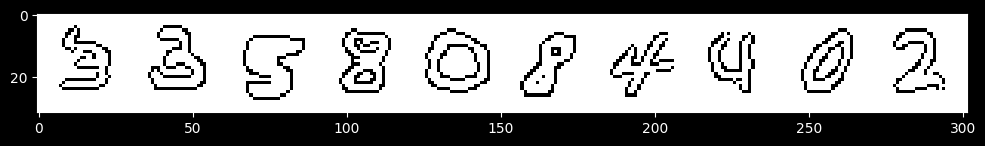

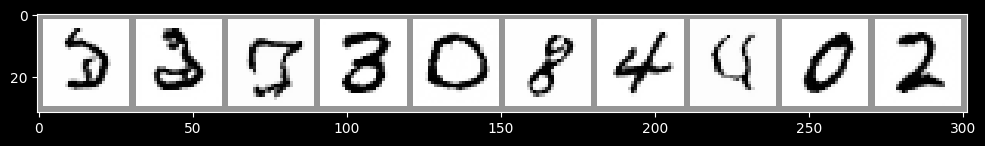

In [163]:
# inference

x = torch.randn(10, 1, 28, 28).to(device)
c = get_canny(next(iter(train_loader))[0][:10]).to(device)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(c.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')
generate(cond_t2i, scheduler, num=10, cond=c)

## refs

- controlnet paper: https://arxiv.org/pdf/2302.05543
- original implementation: https://github.com/lllyasviel/ControlNet/blob/main/cldm/cldm.py#L147
- implementation in diffusers: https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/models/unets/unet_2d_condition.py#L71
- t2i paper: https://arxiv.org/pdf/2302.08453
- t2i diffusers implmentation: https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/models/unets/unet_2d_condition.py#L382
